In [27]:
#import necessary libraries
import os 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.layers import GlobalAveragePooling2D, Conv2D, Dense, BatchNormalization, Dropout, MaxPooling2D, Flatten
from keras.models import Model,load_model
from keras.callbacks import ModelCheckpoint
from datetime import datetime
import tensorflow as tf
from keras.metrics import Precision, Recall
from keras import backend as K


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install tensorflow-gpu

     |████████████████████████████████| 489.6 MB 5.2 kB/s 


In [4]:
!nvidia-smi

Wed Nov 17 14:34:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [26]:
!curl https://colab.chainer.org/install | CHAINER_VERSION="==5.1.0" CUPY_VERSION="==5.1.0" sh -


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   3354      0 --:--:-- --:--:-- --:--:--  3361
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 64 not upgraded.
+ pip install -q cupy-cuda100 ==5.1.0 chainer ==5.1.0
     |████████████████████████████████| 298.6 MB 2.8 kB/s 
     |████████████████████████████████| 513 kB 52.2 MB/s 
+ set +ex
Installation succeeded!


In [29]:
import chainer
chainer.print_runtime_info()

Platform: Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 5.1.0
NumPy: 1.19.5
CuPy:
  CuPy Version          : 5.1.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10000
  CUDA Driver Version   : 11020
  CUDA Runtime Version  : 10000
  cuDNN Build Version   : 7301
  cuDNN Version         : 7301
  NCCL Build Version    : 2307
iDeep: 2.0.0.post3


In [5]:
#read training data
train_path = '/content/drive/MyDrive/ML Project/train_images'
train_image_names = os.listdir(train_path)
train_label = pd.read_csv('/content/drive/MyDrive/ML Project/train.csv')
train_label

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [6]:
#create a data frame of with column image id and class id to perform join operation on given train.csv
tr_img_id = []
tr_cls_id = []
for i in train_image_names:
  tr_img_id.append(i)
  tr_cls_id.append(1)
  tr_img_id.append(i)
  tr_cls_id.append(2)
  tr_img_id.append(i)
  tr_cls_id.append(3)
  tr_img_id.append(i)
  tr_cls_id.append(4)

In [7]:
train_img_nms = pd.DataFrame(tr_img_id,columns=['ImageId'])
train_img_nms['ClassId'] = tr_cls_id
train_img_nms

,ImageId,ClassId
0,eb27105ee.jpg,1
1,eb27105ee.jpg,2
2,eb27105ee.jpg,3
3,eb27105ee.jpg,4
4,eb0969906.jpg,1
...,...,...
50467,09d87038e.jpg,4
50468,0a26aceb2.jpg,1
50469,0a26aceb2.jpg,2
50470,0a26aceb2.jpg,3


In [8]:
#perform outer join on dataframe and train_label df on ImageId and ClassId
train_df = pd.merge(train_img_nms, train_label,how='outer',on=['ImageId','ClassId'])
train_df = train_df.fillna('')
train_df

,ImageId,ClassId,EncodedPixels
0,eb27105ee.jpg,1,
1,eb27105ee.jpg,2,
2,eb27105ee.jpg,3,
3,eb27105ee.jpg,4,
4,eb0969906.jpg,1,
...,...,...,...
50467,09d87038e.jpg,4,
50468,0a26aceb2.jpg,1,
50469,0a26aceb2.jpg,2,
50470,0a26aceb2.jpg,3,19347 4 19595 12 19843 20 20091 28 20339 36 20...


In [9]:
#manipulate dataframe
train_data = pd.pivot_table(train_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
train_data = train_data.reset_index()
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
train_data

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,
...,...,...,...,...,...
12613,fff0295e1.jpg,,,,
12614,fff02e9c5.jpg,,,207523 3 207777 9 208030 15 208283 22 208537 2...,
12615,fffe98443.jpg,,,105929 5 106177 14 106424 24 106672 33 106923 ...,
12616,ffff4eaa8.jpg,,,16899 7 17155 20 17411 34 17667 47 17923 60 18...,


In [10]:
tmp = []
for i in range(len(train_data)):
  if all((train_data['Defect_1'][i]=='',train_data['Defect_2'][i]=='',train_data['Defect_3'][i]=='',train_data['Defect_4'][i]=='')):
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect'] = tmp

tmp = []
for i in range(len(train_data)):
  if train_data['Defect_1'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_1'] = tmp

tmp = []
for i in range(len(train_data)):
  if train_data['Defect_2'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_2'] = tmp

tmp = []
for i in range(len(train_data)):
  if train_data['Defect_3'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_3'] = tmp
  
tmp = []
for i in range(len(train_data)):
  if train_data['Defect_4'][i]=='':
    tmp.append(0)
  else:
    tmp.append(1)
train_data['hasDefect_4'] = tmp

train_data

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0
1,00031f466.jpg,,,,,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0
3,000789191.jpg,,,,,0,0,0,0,0
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
12613,fff0295e1.jpg,,,,,0,0,0,0,0
12614,fff02e9c5.jpg,,,207523 3 207777 9 208030 15 208283 22 208537 2...,,1,0,0,1,0
12615,fffe98443.jpg,,,105929 5 106177 14 106424 24 106672 33 106923 ...,,1,0,0,1,0
12616,ffff4eaa8.jpg,,,16899 7 17155 20 17411 34 17667 47 17923 60 18...,,1,0,0,1,0


In [11]:
#data preparation
tmp = []
for i in range(len(train_data)):
  if train_data['hasDefect_2'].iloc[i]==1:
    tmp.append(2)
  elif train_data['hasDefect_4'].iloc[i]==1:
    tmp.append(4)
  elif train_data['hasDefect_1'].iloc[i]==1:
    tmp.append(1)
  elif train_data['hasDefect_3'].iloc[i]==1:
    tmp.append(3)
  else:
    tmp.append(0)
train_data['stratify']=tmp

X = train_data.copy()
X_train, X_test = train_test_split(X, test_size = 0.1, stratify = X['stratify'],random_state=42)
X_train, X_val = train_test_split(X_train, test_size = 0.2, stratify = X_train['stratify'],random_state=42)
X_train = X_train.drop(['stratify'], axis = 1)
X_val = X_val.drop(['stratify'], axis = 1)
X_test = X_test.drop(['stratify'], axis = 1)
print(X_train.shape, X_val.shape, X_test.shape)

(9084, 10) (2272, 10) (1262, 10)


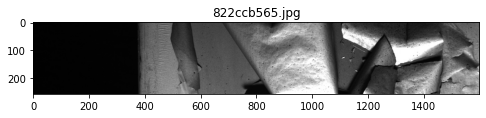

(1600, 256)


In [12]:
#Display train image
fig, ax =plt.subplots(1,1,figsize=(8,7))
img= Image.open(str(train_path + '/' + X_train.ImageId.iloc[100]))
plt.imshow(img)
ax.set_title(X_train.ImageId.iloc[0])
plt.show()
print(img.size)

No. of Images in train set:  9084 
 --------------------------------------------------


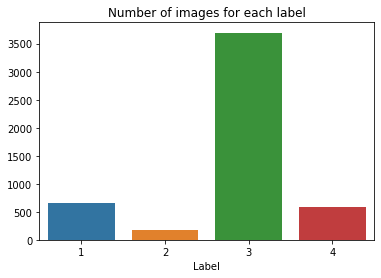

No. of Images having: Label 1 = 648, Label 2 = 178, Label 3 = 3695, Label 4 = 577 
 --------------------------------------------------


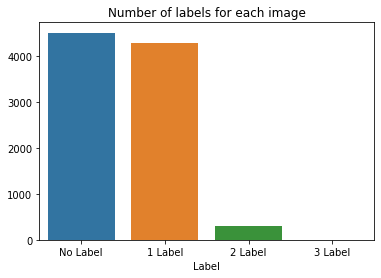

No. of Images with no defects: 4285, with only one label: 4502, with two labels: 295, with three labels: 2


In [13]:
print("No. of Images in train set: ", X_train.shape[0],'\n','-'*50)

tmp = [sum(X_train['hasDefect_1']==1),
       sum(X_train['hasDefect_2']==1),
       sum(X_train['hasDefect_3']==1),
       sum(X_train['hasDefect_4']==1)]
fig, ax = plt.subplots()
sns.barplot(x=['1','2','3','4'],y=tmp)
ax.set_title("Number of images for each label")
ax.set_xlabel("Label")
plt.show()
print("No. of Images having: Label 1 = {}, Label 2 = {}, Label 3 = {}, Label 4 = {}".format(tmp[0],tmp[1],tmp[2],tmp[3]),'\n','-'*50)

tmp = (X_train['hasDefect_1']+X_train['hasDefect_2']+X_train['hasDefect_3']+X_train['hasDefect_4']).value_counts()
fig, ax = plt.subplots()
sns.barplot(x=['No Label','1 Label','2 Label','3 Label'],y=tmp)
ax.set_title("Number of labels for each image")
ax.set_xlabel("Label")
plt.show()
print("No. of Images with no defects: {}, with only one label: {}, with two labels: {}, with three labels: {}".format(tmp[0],tmp[1],tmp[2],tmp[3]))

Sample images with no defects:


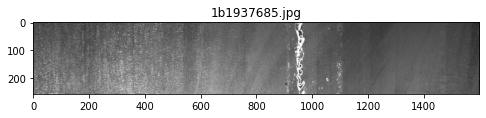

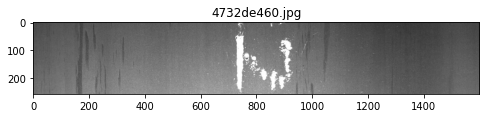

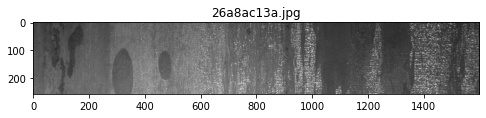

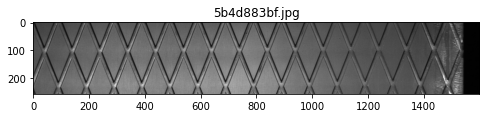

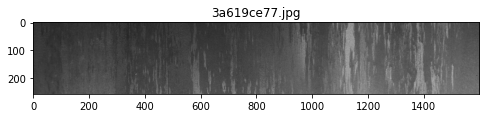

In [14]:
# 5 images having no defects
tmp = []
cnt=0
print("Sample images with no defects:")
for i in X_train['ImageId'][X_train['hasDefect']==0]:
    if cnt<5:
        fig, ax = plt.subplots(1,1,figsize=(8, 7))
        img = Image.open(str(train_path +"/"+ i))
        plt.imshow(img)
        ax.set_title(i)
        plt.show()
        cnt+=1

In [15]:
# We need a function to convert EncodedPixels into mask

def rle2mask(encoded_pixels, shape=(1600,256)):
    s = encoded_pixels.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

Sample images with Class 1 defect:


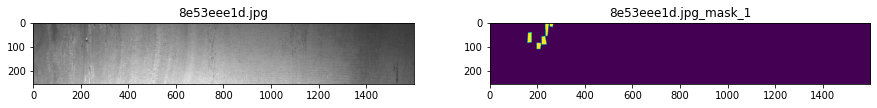

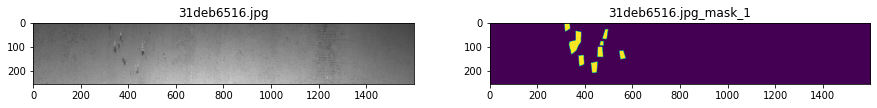

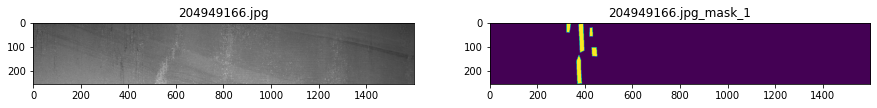

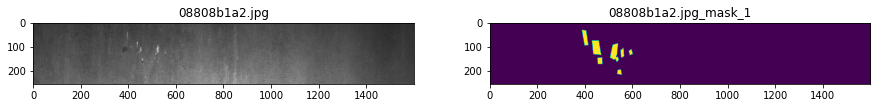

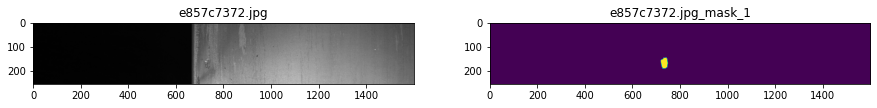

--------------------------------------------------------------------------------
Sample images with Class 2 defect:


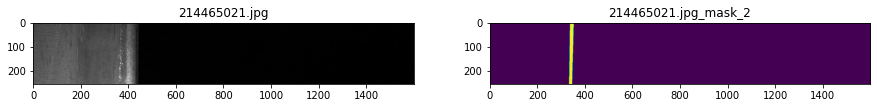

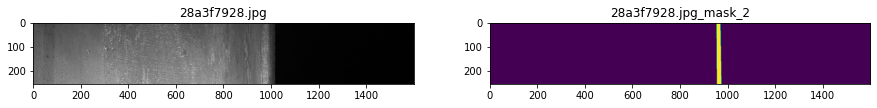

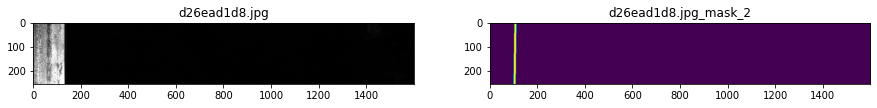

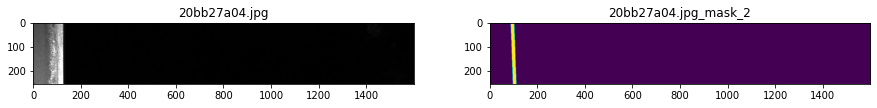

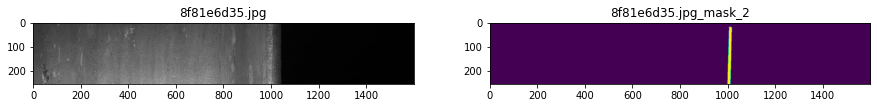

--------------------------------------------------------------------------------
Sample images with Class 3 defect:


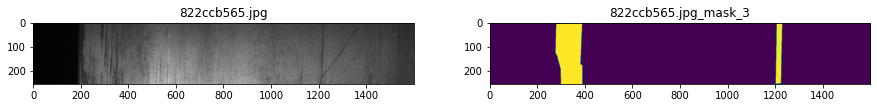

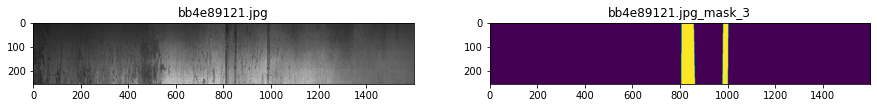

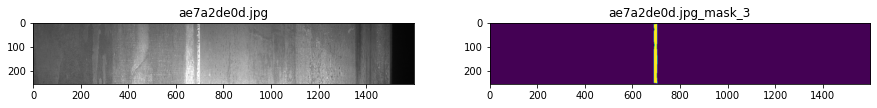

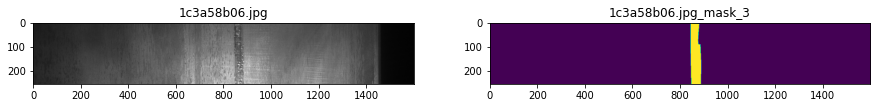

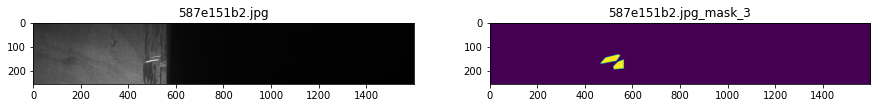

--------------------------------------------------------------------------------
Sample images with Class 4 defect:


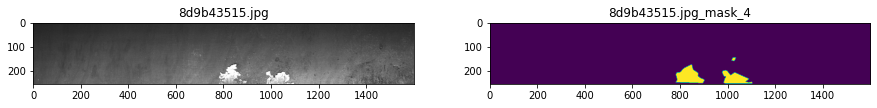

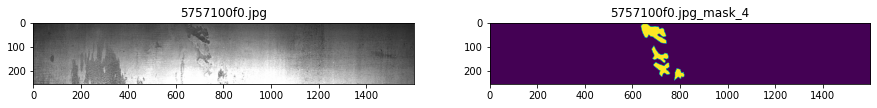

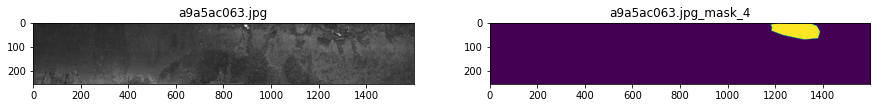

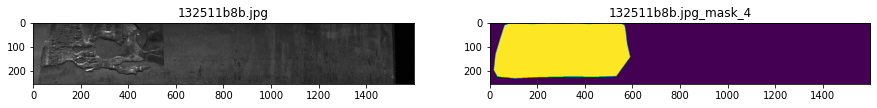

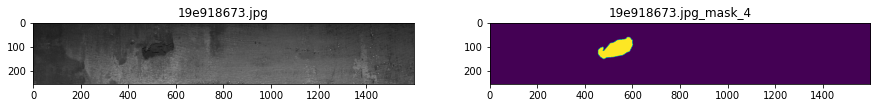

--------------------------------------------------------------------------------


In [15]:
# Visualization: Sample images having defect
for k in [1,2,3,4]:
    tmp = []
    cnt=0
    print("Sample images with Class {} defect:".format(k))
    for i in X_train[X_train[f'hasDefect_{k}']==1][['ImageId',f'Defect_{k}']].values:
        if cnt<5:
            fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 7))
            img = Image.open(str(train_path +"/"+ i[0]))
            ax1.imshow(img)
            ax1.set_title(i[0])
            cnt+=1
            ax2.imshow(rle2mask(i[1]))
            ax2.set_title(i[0]+'_mask_'+str(k))
            plt.show()
    print('-'*80)

In [16]:
#Data preparation
X_train_binary = X_train[['ImageId','hasDefect']]
X_val_binary = X_val[['ImageId','hasDefect']]
X_test_binary = X_test[['ImageId','hasDefect']]

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_binary.shape, X_val_binary.shape, X_test_binary.shape)

(9084, 10) (2272, 10) (1262, 10)
(9084, 2) (2272, 2) (1262, 2)


In [17]:
# DataGenerator for the binary classification model with image augmentations

train_DataGenerator_1 = ImageDataGenerator(
                                           rescale=1./255., shear_range=0.2, zoom_range=0.05, 
                                           rotation_range=5,width_shift_range=0.2, height_shift_range=0.2, 
                                           horizontal_flip=True, vertical_flip=True
                                           )

test_DataGenerator_1 = ImageDataGenerator(rescale=1./255) #test data only need rescaling

train_generator = train_DataGenerator_1.flow_from_dataframe(dataframe=X_train_binary.astype(str),
                                                            directory=train_path,x_col="ImageId",
                                                            y_col="hasDefect",target_size=(280,280),
                                                            batch_size=32,
                                                            class_mode='binary')

validation_generator = test_DataGenerator_1.flow_from_dataframe(dataframe=X_val_binary.astype(str),
                                                                directory=train_path,x_col="ImageId",
                                                                y_col="hasDefect",target_size=(280,280),
                                                                batch_size=32,class_mode='binary')

Found 9084 validated image filenames belonging to 2 classes.
Found 2272 validated image filenames belonging to 2 classes.


In [18]:
# Using a pretrained model from keras for classification: 
# Selecting Xception pretrained model

base_model = keras.applications.xception.Xception(include_top = False, weights='imagenet', input_shape = (280,280,3))

for layer in base_model.layers:
  layer.trainable = False 

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu')(x)

# and the prediction layer
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

83697664/83683744 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 280, 280, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 139, 139, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 139, 139, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['acc',Precision(),Recall()])
logdir = "/content/drive/MyDrive/ML Project/Results/"+'Binary_Classifier_'+datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/ML Project/Results/binary_classifier.h5', 
                     monitor='acc', mode='max', verbose=1, save_best_only=True)
history = model.fit(train_generator, validation_data = validation_generator, epochs = 10, verbose=1, callbacks = [model_checkpoint])

Epoch 1/10
284/284 [==============================] - 1174s 4s/step - loss: 0.4520 - acc: 0.7802 - precision_1: 0.7831 - recall_1: 0.8075 - val_loss: 0.4088 - val_acc: 0.8182 - val_precision_1: 0.7615 - val_recall_1: 0.9550

Epoch 00001: acc improved from -inf to 0.78016, saving model to /content/drive/MyDrive/ML Project/Results/binary_classifier.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
284/284 [==============================] - 305s 1s/step - loss: 0.3842 - acc: 0.8233 - precision_1: 0.8234 - recall_1: 0.8473 - val_loss: 0.4145 - val_acc: 0.8283 - val_precision_1: 0.7704 - val_recall_1: 0.9617

Epoch 00002: acc improved from 0.78016 to 0.82332, saving model to /content/drive/MyDrive/ML Project/Results/binary_classifier.h5
Epoch 3/10
284/284 [==============================] - 308s 1s/step - loss: 0.3671 - acc: 0.8282 - precision_1: 0.8264 - recall_1: 0.8541 - val_loss: 0.3526 - val_acc: 0.8539 - val_precision_1: 0.8303 - val_recall_1: 0.9092

Epoch 00003: acc improved from 0.82332 to 0.82816, saving model to /content/drive/MyDrive/ML Project/Results/binary_classifier.h5
Epoch 4/10
284/284 [==============================] - 303s 1s/step - loss: 0.3458 - acc: 0.8442 - precision_1: 0.8431 - recall_1: 0.8664 - val_loss: 0.2968 - val_acc: 0.8715 - val_precision_1: 0.8620 - val_recall_1: 0.9008

Epoch 00004: acc improved from 0.82816 to 0.84423, saving model to /

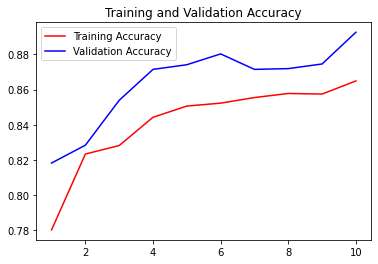

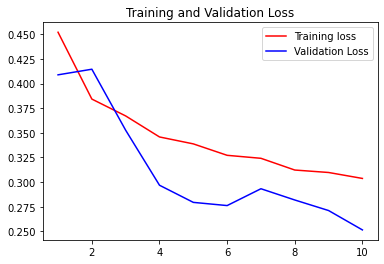

In [ ]:
# Plot the graphs for the metrics of interest
import matplotlib.pyplot as plt

metrics = history.history
acc = metrics['acc']
val_acc = metrics['val_acc']
loss = metrics['loss']
val_loss = metrics['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc,'r',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()


### **Multi Label Classification**

In [29]:
# For clasification
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # calculates number of true positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      # calculates number of actual positives
    recall = true_positives / (possible_positives + K.epsilon())   # K.epsilon takes care of non-zero divisions
    return recall

def precision_m(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # calculates number of true positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))      # calculates number of predicted positives   
    precision = true_positives /(predicted_positives + K.epsilon()) # K.epsilon takes care of non-zero divisions
    return precision
    
def f1_score_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)  # calls precision metric and takes the score of precision of the batch
    recall = recall_m(y_true, y_pred)        # calls recall metric and takes the score of precision of the batch
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

dependencies = {
    'recall_m':recall_m,
    'precision_m':precision_m,
    'f1_score_m':f1_score_m,
}

In [16]:
X_train_multi = X_train[['ImageId','hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']][X_train['hasDefect']==1]
X_val_multi = X_val[['ImageId','hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']][X_val['hasDefect']==1]
X_test_multi = X_test[['ImageId','hasDefect_1','hasDefect_2','hasDefect_3','hasDefect_4']][X_test['hasDefect']==1]

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_multi.shape, X_val_multi.shape, X_test_multi.shape)

(9084, 10) (2272, 10) (1262, 10)
(4799, 5) (1200, 5) (667, 5)


In [25]:
# DataGenerator for the multi label classification model with image augmentations
train_DataGenerator_2 = ImageDataGenerator(rescale=1./255., shear_range=0.2, 
                                           zoom_range=0.05, rotation_range=5,
                                           width_shift_range=0.2, height_shift_range=0.2, 
                                           horizontal_flip=True, vertical_flip=True)

test_DataGenerator_2 = ImageDataGenerator(rescale=1./255)

train_generator = train_DataGenerator_2.flow_from_dataframe(
                                        dataframe=X_train_multi,
                                        directory= train_path,
                                        x_col="ImageId", y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                        target_size=(256,512), batch_size=32, class_mode='raw')



validation_generator = test_DataGenerator_2.flow_from_dataframe(
                                       dataframe=X_val_multi,
                                       directory= train_path,
                                       x_col="ImageId", y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                       target_size=(256,512), batch_size=32, class_mode='raw')

Found 4799 validated image filenames.
Found 1200 validated image filenames.


Custom Model

In [18]:
model = tf.keras.models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(256,512,3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 512, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 512, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 256, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 256, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 256, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 256, 64)      1

In [31]:
# compile model
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc',f1_score_m,precision_m,recall_m])

In [32]:
#training
logdir = "/content/drive/MyDrive/ML Project/Results/"+datetime.now().strftime("%Y%m%d-%H%M%S")+'_Multi_Label_Classifier'
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
mc = ModelCheckpoint('/content/drive/MyDrive/ML Project/Results/Best_models/Multi_Label_classifier_costom_model.h5', 
                     monitor='accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(train_generator, validation_data = validation_generator, epochs = 20, verbose=1,callbacks = [mc])

Epoch 1/20
150/150 [==============================] - 3114s 21s/step - loss: 0.5411 - acc: 0.5924 - f1_score_m: 0.5886 - precision_m: 0.5581 - recall_m: 0.6381 - val_loss: 0.3867 - val_acc: 0.7592 - val_f1_score_m: 0.7497 - val_precision_m: 0.7736 - val_recall_m: 0.7277
Epoch 2/20
150/150 [==============================] - 221s 1s/step - loss: 0.3698 - acc: 0.7306 - f1_score_m: 0.7226 - precision_m: 0.7337 - recall_m: 0.7133 - val_loss: 0.3774 - val_acc: 0.7592 - val_f1_score_m: 0.7448 - val_precision_m: 0.7782 - val_recall_m: 0.7150
Epoch 3/20
150/150 [==============================] - 221s 1s/step - loss: 0.3497 - acc: 0.7391 - f1_score_m: 0.7364 - precision_m: 0.7497 - recall_m: 0.7249 - val_loss: 0.3894 - val_acc: 0.7433 - val_f1_score_m: 0.7335 - val_precision_m: 0.7170 - val_recall_m: 0.7520
Epoch 4/20
150/150 [==============================] - 219s 1s/step - loss: 0.3322 - acc: 0.7474 - f1_score_m: 0.7421 - precision_m: 0.7552 - recall_m: 0.7312 - val_loss: 0.4533 - val_acc: 0.7

In [ ]:
# Loading best model trained on multi label classification
model_multi = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/Multi_Label_classifier.h5')

In [ ]:
Eval_DataGenerator_2 = ImageDataGenerator(rescale=1./255)

train_generator_eval = Eval_DataGenerator_2.flow_from_dataframe(
                                dataframe=X_train_multi,
                                directory= train_path,
                                x_col="ImageId", y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                target_size=(256,512), batch_size=16, class_mode='raw' )

val_generator_eval = Eval_DataGenerator_2.flow_from_dataframe(
                                dataframe=X_val_multi,
                                directory= train_path,
                                x_col="ImageId", y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                target_size=(256,512), batch_size=16, class_mode='raw' )
test_generator_eval = Eval_DataGenerator_2.flow_from_dataframe(
                                dataframe=X_test_multi,
                                directory= train_path,
                                x_col="ImageId", y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                target_size=(256,512), batch_size=16, class_mode='raw' )

Found 4799 validated image filenames.
Found 1200 validated image filenames.
Found 667 validated image filenames.


In [ ]:
train_eval_rslt=model_multi.evaluate(train_generator_eval,verbose=1)
print('Train set evaluation score:')
pd.DataFrame(train_eval_rslt,columns = [' '], index=['binary_crossentropy','acc','precision','recall'])

300/300 [==============================] - 60s 199ms/step - loss: 0.4204 - accuracy: 0.5676 - precision_1: 0.6185 - recall_1: 0.5836
Train set evaluation score:


,
binary_crossentropy,0.420365
acc,0.567618
precision,0.618503
recall,0.583562


In [ ]:
val_eval_rslt=model_multi.evaluate(val_generator_eval,verbose=1)
print('Validation set evaluation score:')
pd.DataFrame(train_eval_rslt,columns = [' '], index=['binary_crossentropy','acc','precision','recall'])

75/75 [==============================] - 15s 198ms/step - loss: 0.4095 - accuracy: 0.5983 - precision_1: 0.6588 - recall_1: 0.6149
Validation set evaluation score:


,
binary_crossentropy,0.420365
acc,0.567618
precision,0.618503
recall,0.583562


In [ ]:
test_eval_rslt=model_multi.evaluate(test_generator_eval,verbose=1)
print('Test set evaluation score:')
pd.DataFrame(train_eval_rslt,columns = [' '], index=['binary_crossentropy','acc','precision','recall'])

42/42 [==============================] - 318s 8s/step - loss: 0.4161 - accuracy: 0.5892 - precision_1: 0.6460 - recall_1: 0.5914
Test set evaluation score:


,
binary_crossentropy,0.420365
acc,0.567618
precision,0.618503
recall,0.583562


In [ ]:
y_pred = model_multi.predict(test_generator_eval)

In [ ]:
y_pred[4]

array([0.00628941, 0.00819677, 0.9070193 , 0.13662374], dtype=float32)

In [ ]:
X_test_multi[["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"]].iloc[4]

hasDefect_1    0
hasDefect_2    0
hasDefect_3    1
hasDefect_4    0
Name: 2269, dtype: int64

### Tranfer learning with Exception 

In [ ]:
# Using a pretrained model from keras for classification: 
# Selecting Xception pretrained model

xception_base_model = keras.applications.xception.Xception(include_top = False, 
                                                           weights='imagenet',
                                                           input_shape = (280,280,3))

for layer in xception_base_model.layers:
  layer.trainable = False 

# add a global spatial average pooling layer
x = xception_base_model.output
x = GlobalAveragePooling2D()(x)

#add some dense layers

x= Dense(1024, activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.2)(x)

x= Dense(512, activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.2)(x)

x= Dense(64, activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.2)(x)

# and the prediction layer
predictions = Dense(4, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=xception_base_model.input, outputs=predictions)
model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 280, 280, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 139, 139, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 139, 139, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 139, 139, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [ ]:
# DataGenerator for the multi label classification model with image augmentations
train_DataGenerator_2 = ImageDataGenerator(rescale=1./255., shear_range=0.2, 
                                           zoom_range=0.05, rotation_range=5,
                                           width_shift_range=0.2, height_shift_range=0.2, 
                                           horizontal_flip=True, vertical_flip=True)


train_generator = train_DataGenerator_2.flow_from_dataframe(
                                        dataframe=X_train_multi,
                                        directory= train_path,
                                        x_col="ImageId", y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                        target_size=(280,280), batch_size=32, class_mode='raw')



validation_generator = test_DataGenerator_2.flow_from_dataframe(
                                       dataframe=X_val_multi,
                                       directory= train_path,
                                       x_col="ImageId", y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                       target_size=(280,280), batch_size=32, class_mode='raw')

Found 4799 validated image filenames.
Found 1200 validated image filenames.


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
#training
logdir = "/content/drive/MyDrive/ML Project/Results/"+datetime.now().strftime("%Y%m%d-%H%M%S")+'_Multi_Label_Classifier_Xception'
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
mc = ModelCheckpoint('/content/drive/MyDrive/ML Project/Results/Best_models/multi_label_classifier_xception.h5', 
                     monitor='accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(train_generator, validation_data = validation_generator, epochs = 20, verbose=1,callbacks = [mc])

Epoch 1/20
150/150 [==============================] - 223s 1s/step - loss: 0.4452 - accuracy: 0.6818 - precision_2: 0.6309 - recall_2: 0.7293 - val_loss: 0.2690 - val_accuracy: 0.8100 - val_precision_2: 0.8376 - val_recall_2: 0.8173

Epoch 00001: accuracy improved from -inf to 0.68181, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/multi_label_classifier_xception.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
150/150 [==============================] - 163s 1s/step - loss: 0.2781 - accuracy: 0.7964 - precision_2: 0.8069 - recall_2: 0.7927 - val_loss: 0.2149 - val_accuracy: 0.8233 - val_precision_2: 0.8353 - val_recall_2: 0.8471

Epoch 00002: accuracy improved from 0.68181 to 0.79642, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/multi_label_classifier_xception.h5
Epoch 3/20
150/150 [==============================] - 165s 1s/step - loss: 0.2514 - accuracy: 0.8012 - precision_2: 0.8154 - recall_2: 0.7970 - val_loss: 0.2031 - val_accuracy: 0.8192 - val_precision_2: 0.8373 - val_recall_2: 0.8518

Epoch 00003: accuracy improved from 0.79642 to 0.80121, saving model to /content/drive/MyDrive/ML Project/Results/Best_models/multi_label_classifier_xception.h5
Epoch 4/20
150/150 [==============================] - 166s 1s/step - loss: 0.2273 - accuracy: 0.8181 - precision_2: 0.8356 - recall_2: 0.8195 - val_loss: 0.2028 - val_accuracy: 0.8150 - val_precision_2: 0.8472 

In [ ]:
Eval_DataGenerator_2 = ImageDataGenerator(rescale=1./255)

train_generator_eval = Eval_DataGenerator_2.flow_from_dataframe(
                                dataframe=X_train_multi,
                                directory= train_path,
                                x_col="ImageId", y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                target_size=(280,280), batch_size=32, class_mode='raw' )

val_generator_eval = Eval_DataGenerator_2.flow_from_dataframe(
                                dataframe=X_val_multi,
                                directory= train_path,
                                x_col="ImageId", y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                target_size=(280,280), batch_size=32, class_mode='raw' )
test_generator_eval = Eval_DataGenerator_2.flow_from_dataframe(
                                dataframe=X_test_multi,
                                directory= train_path,
                                x_col="ImageId", y_col=["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"],
                                target_size=(280,280), batch_size=32, class_mode='raw' )

Found 4799 validated image filenames.
Found 1200 validated image filenames.
Found 667 validated image filenames.


In [ ]:
# Loading best model trained on multi label classification with xception
model_multi_2 = load_model('/content/drive/MyDrive/ML Project/Results/Best_models/multi_label_classifier_xception.h5')

In [ ]:
train_eval_rslt=model_multi_2.evaluate(train_generator_eval,verbose=1)
print('Train set evaluation score:')
pd.DataFrame(train_eval_rslt,columns = [' '], index=['binary_crossentropy','acc','precision','recall'])

150/150 [==============================] - 1147s 7s/step - loss: 0.1548 - accuracy: 0.8681 - precision_4: 0.8846 - recall_4: 0.8707
Train set evaluation score:


,
binary_crossentropy,0.154760
acc,0.868098
precision,0.884615
recall,0.870734


In [ ]:
val_eval_rslt=model_multi_2.evaluate(val_generator_eval,verbose=1)
print('Validation set evaluation score:')
pd.DataFrame(train_eval_rslt,columns = [' '], index=['binary_crossentropy','acc','precision','recall'])

38/38 [==============================] - 302s 8s/step - loss: 0.1703 - accuracy: 0.8500 - precision_4: 0.8725 - recall_4: 0.8588
Validation set evaluation score:


,
binary_crossentropy,0.154760
acc,0.868098
precision,0.884615
recall,0.870734


In [ ]:
test_eval_rslt=model_multi_2.evaluate(test_generator_eval,verbose=1)
print('Test set evaluation score:')
pd.DataFrame(train_eval_rslt,columns = [' '], index=['binary_crossentropy','acc','precision','recall'])

21/21 [==============================] - 157s 8s/step - loss: 0.1590 - accuracy: 0.8411 - precision_4: 0.8784 - recall_4: 0.8601
Test set evaluation score:


,
binary_crossentropy,0.154760
acc,0.868098
precision,0.884615
recall,0.870734


In [ ]:
y_pred = model_multi_2.predict(test_generator_eval)

In [ ]:
print(y_pred[0])
list(X_test_multi[["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"]].iloc[0])

[9.1935638e-03 8.5890834e-04 9.8561317e-01 1.8817711e-03]


[0, 0, 1, 1]

In [ ]:
print(y_pred[1])
list(X_test_multi[["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"]].iloc[1])

[0.03868441 0.00158107 0.97904027 0.00162996]


[0, 0, 1, 0]

In [ ]:
print(y_pred[20])
list(X_test_multi[["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"]].iloc[20])

[0.3876704  0.7550668  0.13249853 0.00365586]


[0, 0, 1, 0]

In [ ]:
print(y_pred[110])
list(X_test_multi[["hasDefect_1","hasDefect_2","hasDefect_3","hasDefect_4"]].iloc[110])

[4.6913628e-02 8.9115225e-04 9.7410101e-01 1.4130892e-04]


[0, 0, 1, 0]

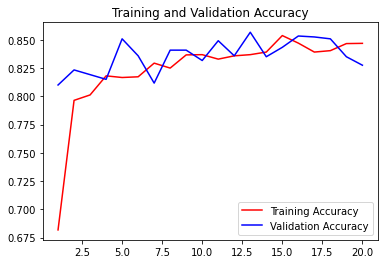

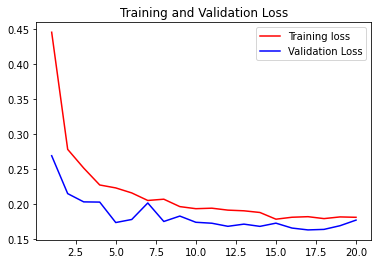

In [ ]:
# Plot the graphs for the metrics of interest
import matplotlib.pyplot as plt

metrics = history.history
acc = metrics['accuracy']
val_acc = metrics['val_accuracy']
loss = metrics['loss']
val_loss = metrics['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs, acc,'r',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()